# Phasing Analyses

In [1]:
# Import packages.
import analysis_functions as af
import allel
import gzip
import numpy as np
import pandas as pd
# Print version numbers.
print('allel', allel.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)

allel 1.3.5
numpy 1.22.3
pandas 1.4.2


## Synthetic Neanderthal Phasing

In [2]:
# Load the synthetic phased data.
alt_syn_den_ref_tgp_df = pd.read_csv(
    '../vcf_data/phasing/alt_syn_nean_den_phased_ref_panel_all_inds.vcf.gz',
    sep='\t', skiprows=8,
)

In [3]:
# Show the dataframe.
alt_syn_den_ref_tgp_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AltaiNeandertal,SyntheticNeanderthal,Denisova
0,12,40759107,rs537731253,C,T,.,PASS,.,GT,0|0,0|0,0|0
1,12,40759130,rs555823387,G,A,.,PASS,.,GT,0|0,0|0,0|0
2,12,40759416,rs375901760,G,A,.,PASS,.,GT,0|0,0|0,0|0
3,12,40759539,rs150100942,T,G,.,PASS,.,GT,0|0,0|0,0|0
4,12,40759590,rs563734242,T,C,.,PASS,.,GT,0|0,0|0,0|0


In [4]:
# Grab the denisovan and altai haplotypes.
den_hap = np.array([int(gt[0]) for gt in alt_syn_den_ref_tgp_df['Denisova'].values])
alt_hap = np.array([int(gt[0]) for gt in alt_syn_den_ref_tgp_df['AltaiNeandertal'].values])
# Determine the fixed differences.
den_alt_is_fxd = den_hap != alt_hap
# Grab the synthetic individual.
alt_syn_den_ref_tgp_data = alt_syn_den_ref_tgp_df['SyntheticNeanderthal'].values
# Extract the synthetic phased haplotypes.
alt_syn_den_ref_tgp_hap1 = np.array([int(gt[0]) for gt in alt_syn_den_ref_tgp_data])
alt_syn_den_ref_tgp_hap2 = np.array([int(gt[2]) for gt in alt_syn_den_ref_tgp_data])
# Intialize a dataframe with the synthetic phasing results.
alt_syn_den_ref_tgp_info = {
    'POS': alt_syn_den_ref_tgp_df['POS'].values[den_alt_is_fxd],
    'Denisovan': den_hap[den_alt_is_fxd],
    'Synthetic Nean. Hap. 1': alt_syn_den_ref_tgp_hap2[den_alt_is_fxd],
    'Synthetic Nean. Hap. 2': alt_syn_den_ref_tgp_hap1[den_alt_is_fxd],
    'Altai Nean.': alt_hap[den_alt_is_fxd],
}
# Convert to a dataframe.
alt_syn_den_ref_tgp_info_df = pd.DataFrame(alt_syn_den_ref_tgp_info)

In [5]:
alt_syn_den_ref_tgp_info_df.head()

,POS,Denisovan,Synthetic Nean. Hap. 1,Synthetic Nean. Hap. 2,Altai Nean.
0,40760764,0,0,1,1
1,40761946,0,0,1,1
2,40777658,0,0,1,1
3,40783148,0,0,1,1
4,40786828,0,0,1,1


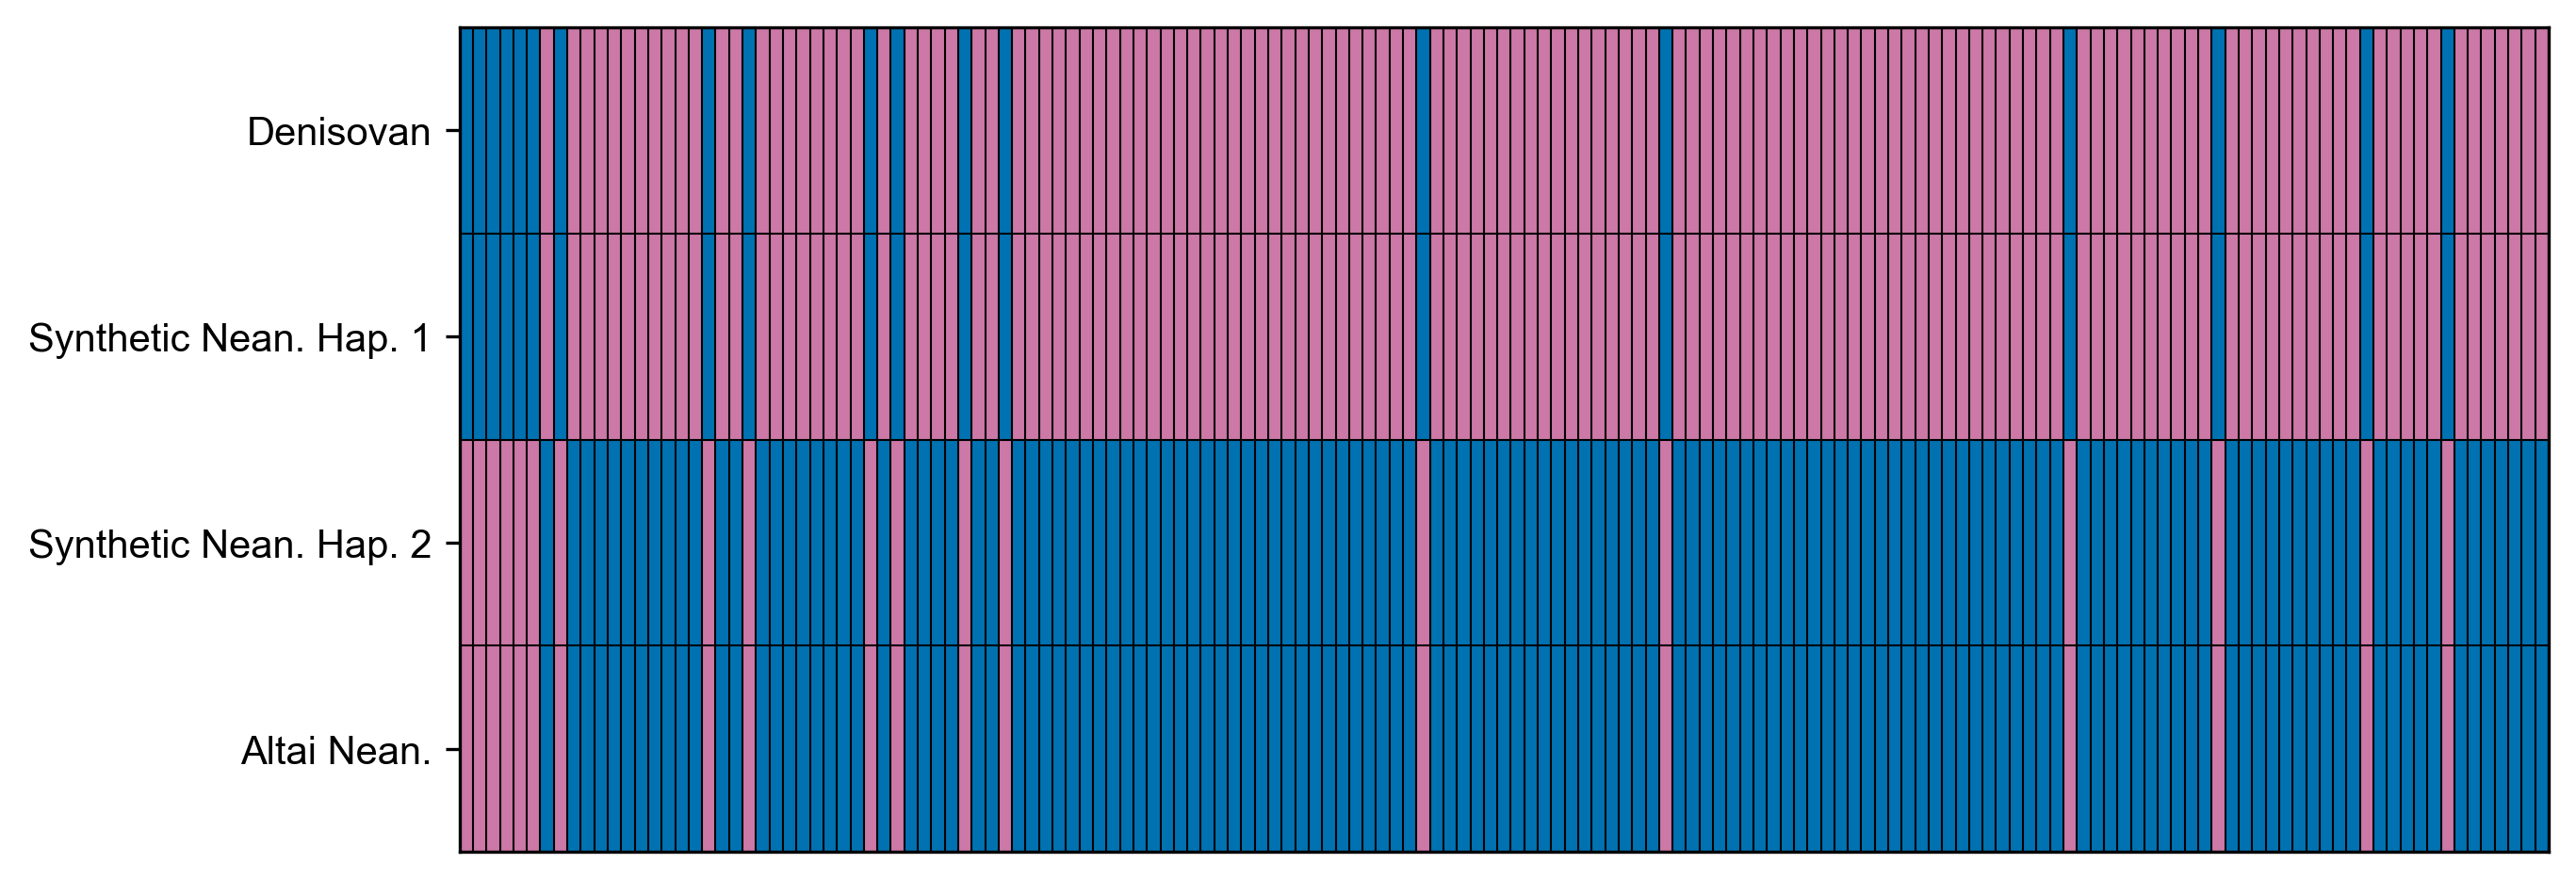

In [6]:
# Plot the results from phasing the synthetic neanderthal.
af.plot_syn_nea_phased_df(alt_syn_den_ref_tgp_info_df)

## Empirical Late Neanderthal Phasing

In [7]:
# Load in the meta information as a pandas dataframe.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Intialize dictionaries with the archaic indicies.
tgp_arc_idx = {
    'ALT': np.array([2347]), 'CHA': np.array([2348]),
    'VIN': np.array([2349]), 'DEN': np.array([2350]),
}
# Intialize a list of archaics.
arc_ids = ['ALT', 'CHA', 'VIN', 'DEN']
# Intialize a dictionary of superpopulation ids.
tgp_spop_ids = ['AFR', 'EUR', 'EAS', 'SAS', 'AMR']
# Intialize a dictionary to store the tgp indicies.
tgp_idx_dicc = {}
# For every superpopulation.
for spop in tgp_df.SUPERPOP.unique():
    # Fill the dictionary.
    tgp_idx_dicc[spop] = tgp_df[tgp_df['SUPERPOP'] == spop].index.values
# For every population.
for pop in tgp_df.POP.unique():
    # Fill the dictionary.
    tgp_idx_dicc[pop] = tgp_df[tgp_df['POP'] == pop].index.values

In [8]:
# Load the genotype matrix.
tgp_arcs_no_aa_72kb_gt, tgp_arcs_no_aa_72kb_pos = af.load_hap_region('tgp_arcs_masked_no_aa', 12, 40759001, 40831000)
# Load all of the emprical phasing results.
cha_ref_tgp_gt, cha_ref_tgp_pos = af.load_phased_gt_pos('cha_phased_ref_panel_all_inds')
vin_ref_tgp_gt, vin_ref_tgp_pos = af.load_phased_gt_pos('vin_phased_ref_panel_all_inds')

In [9]:
# Intialize a dictionary.
aaf_72kb = {
    'POS': tgp_arcs_no_aa_72kb_pos,
}
# For every superpopulation.
for spop in tgp_spop_ids:
    # Update the dictionary.
    aaf_72kb[spop] = af.calc_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(tgp_idx_dicc[spop], axis=1))
# For every archaic.
for arc in arc_ids:
    # Update the dictionary.
    aaf_72kb[arc] = af.calc_ind_alt_freqs(tgp_arcs_no_aa_72kb_gt.take(tgp_arc_idx[arc], axis=1))
# Convert the dictionary to a dataframe.
aaf_72kb_df = pd.DataFrame(aaf_72kb)

In [10]:
# Create the masks of interest.
tgp_seg_72kb = tgp_arcs_no_aa_72kb_gt.take(tgp_df.index.values, axis=1).count_alleles().is_segregating()
den_alt_fxd_72kb = af.pwd_per_site(aaf_72kb['DEN'], aaf_72kb['ALT']) == 1
den_het_72kb = aaf_72kb['DEN'] == 0.5
alt_het_72kb = aaf_72kb['ALT'] == 0.5
cha_het_72kb = aaf_72kb['CHA'] == 0.5
vin_het_72kb = aaf_72kb['VIN'] == 0.5

In [11]:
# Determine the sites that need to be resolved manually for Chagyrskaya.
cha_het_to_resolve = tgp_arcs_no_aa_72kb_pos[cha_het_72kb & ~den_alt_fxd_72kb & ~tgp_seg_72kb]
# Show the dataframe for these sites
aaf_72kb_df[cha_het_72kb & ~den_alt_fxd_72kb & ~tgp_seg_72kb]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
177,40767590,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,0.0
1406,40821807,0.0,0.0,0.0,0.0,0.0,NaN,0.5,0.5,0.0
1534,40826155,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,NaN
1599,40828121,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,0.0


In [12]:
# Determine the sites that need to be resolved manually for Vindija.
vin_het_to_resolve = tgp_arcs_no_aa_72kb_pos[vin_het_72kb & ~den_alt_fxd_72kb & ~tgp_seg_72kb]
# Show the dataframe for these sites
aaf_72kb_df[vin_het_72kb & ~den_alt_fxd_72kb & ~tgp_seg_72kb]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
143,40765370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
389,40783344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1406,40821807,0.0,0.0,0.0,0.0,0.0,NaN,0.5,0.5,0.0
1473,40824215,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.5,NaN
1630,40829306,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0


### Chagyrskaya Nean.

In [13]:
# Intialize the haplotype dictionary.
cha_ref_tgp_info = {
    'POS': cha_ref_tgp_pos,
    'Altai Nean. Dip.': aaf_72kb['ALT'][np.isin(tgp_arcs_no_aa_72kb_pos, cha_ref_tgp_pos)],
    'Chagyrskaya Nean. Hap. 1': cha_ref_tgp_gt[:, 1, 0],
    'Chagyrskaya Nean. Hap. 2': cha_ref_tgp_gt[:, 1, 1],
    'Denisovan Dip.': aaf_72kb['DEN'][np.isin(tgp_arcs_no_aa_72kb_pos, cha_ref_tgp_pos)],
}
# Convert the dictionary to a dataframe.
cha_ref_tgp_info_df = pd.DataFrame(cha_ref_tgp_info)

In [14]:
# Intialize the positions of the het sites.
cha_het_pos_72kb = tgp_arcs_no_aa_72kb_pos[cha_het_72kb]
# Intialize a dictionary.
cha_to_resolve_info = {
    'Late Neanderthal': [],
    'Het. Pos. to Resolve': [],
    'Preceding Het. Pos.': [],
    'Dist. to Preceding Het. Pos.': [],
    'Proceeding Het. Pos.': [],
    'Dist. to Proceeding Het. Pos.': [],
}
# For every focal position.
for pos in cha_het_to_resolve:
    # Find the index.
    pos_idx = np.where(cha_het_pos_72kb == pos)[0][0]
    # If the het site is the last het site.
    if pos_idx == (cha_het_pos_72kb.size - 1):
        # Update the dictionary.
        cha_to_resolve_info['Late Neanderthal'].append('Chagyrskaya Nean.')
        cha_to_resolve_info['Het. Pos. to Resolve'].append(pos)
        cha_to_resolve_info['Preceding Het. Pos.'].append(cha_het_pos_72kb[pos_idx-1])
        cha_to_resolve_info['Dist. to Preceding Het. Pos.'].append(pos - cha_het_pos_72kb[pos_idx-1])
        cha_to_resolve_info['Proceeding Het. Pos.'].append(-1)
        cha_to_resolve_info['Dist. to Proceeding Het. Pos.'].append(-1)
    # Else.
    else:
        # Update the dictionary.
        cha_to_resolve_info['Late Neanderthal'].append('Chagyrskaya Nean.')
        cha_to_resolve_info['Het. Pos. to Resolve'].append(pos)
        cha_to_resolve_info['Preceding Het. Pos.'].append(cha_het_pos_72kb[pos_idx-1])
        cha_to_resolve_info['Dist. to Preceding Het. Pos.'].append(pos - cha_het_pos_72kb[pos_idx-1])
        cha_to_resolve_info['Proceeding Het. Pos.'].append(cha_het_pos_72kb[pos_idx+1])
        cha_to_resolve_info['Dist. to Proceeding Het. Pos.'].append(cha_het_pos_72kb[pos_idx+1] - pos)
# Convert the dictionary to a dataframe.
cha_to_resolve_info_df = pd.DataFrame(cha_to_resolve_info)

In [15]:
# Show the het sites to be resolved info.
cha_to_resolve_info_df

,Late Neanderthal,Het. Pos. to Resolve,Preceding Het. Pos.,Dist. to Preceding Het. Pos.,Proceeding Het. Pos.,Dist. to Proceeding Het. Pos.
0,Chagyrskaya Nean.,40767590,40761946,5644,40768905,1315
1,Chagyrskaya Nean.,40821807,40821795,12,40821847,40
2,Chagyrskaya Nean.,40826155,40826138,17,40826201,46
3,Chagyrskaya Nean.,40828121,40828019,102,40828306,185


* 40767590
    * Not resolvable
* 40821807
    * 40821795 - 40821807 - 40821847: G - C - C & A - T - A
* 40826155
    * 40826138 - 40826155: T - A & G - G
    * 40826138 - 40826155 - 40826201: T - A - G & G - G - A
* 40828121
    * 40828019 - 40828121: T - A & C - A  (too few overlapping reads)

In [16]:
# Intialize tha manual phasing results.
cha_is_resolved = [
    False,
    True,
    True,
    False,
]
cha_is_resolved_info = [
    'Distant Flanking Het. Sites',
    'G-C-C and A-T-A',
    'T-A-G and G-G-A',
    'Not Enough Overlapping Reads',
]
# Update the dictioanry.
cha_to_resolve_info_df['Is Resvolable?'] = cha_is_resolved
cha_to_resolve_info_df['Phasing Info.'] = cha_is_resolved_info
# Export the dataframe.
# cha_to_resolve_info_df.to_csv('./dataframes/chagyrskaya_nean_manual_phasing_info.csv.gz', index=False)

In [17]:
# Show the het sites to be resolved info.
cha_to_resolve_info_df

,Late Neanderthal,Het. Pos. to Resolve,Preceding Het. Pos.,Dist. to Preceding Het. Pos.,Proceeding Het. Pos.,Dist. to Proceeding Het. Pos.,Is Resvolable?,Phasing Info.
0,Chagyrskaya Nean.,40767590,40761946,5644,40768905,1315,False,Distant Flanking Het. Sites
1,Chagyrskaya Nean.,40821807,40821795,12,40821847,40,True,G-C-C and A-T-A
2,Chagyrskaya Nean.,40826155,40826138,17,40826201,46,True,T-A-G and G-G-A
3,Chagyrskaya Nean.,40828121,40828019,102,40828306,185,False,Not Enough Overlapping Reads


In [18]:
# Show the flanking het sites for the first focal het.
# 40821807: hap1 = 1, hap2 = 0.
# ALT = np.nan, DEN = 0.
cha_ref_tgp_info_df[np.isin(cha_ref_tgp_info_df['POS'].values, [40821795, 40821847])]

,POS,Altai Nean. Dip.,Chagyrskaya Nean. Hap. 1,Chagyrskaya Nean. Hap. 2,Denisovan Dip.
1278,40821795,0.0,0,1,1.0
1280,40821847,NaN,0,1,NaN


In [19]:
# Show the flanking het sites for the second focal het.
# 40826155: hap1 = 0, hap2 = 1.
# ALT = 0, DEN = np.nan.
cha_ref_tgp_info_df[np.isin(cha_ref_tgp_info_df['POS'].values, [40826138, 40826201])]

,POS,Altai Nean. Dip.,Chagyrskaya Nean. Hap. 1,Chagyrskaya Nean. Hap. 2,Denisovan Dip.
1390,40826138,0.0,0,1,NaN
1392,40826201,0.0,0,1,1.0


In [20]:
# Find the information for the focal het sites.
aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [40821807, 40826155])]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
1406,40821807,0.0,0.0,0.0,0.0,0.0,NaN,0.5,0.5,0.0
1534,40826155,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,NaN


In [21]:
# Update the positions list.
cha_phased_pos = np.sort(np.append(cha_ref_tgp_info_df['POS'].values, [40821807, 40826155]))
# Create a mask.
cha_phased_pos_mask = np.isin(tgp_arcs_no_aa_72kb_pos, cha_phased_pos)
# Intialize a dictionary.
cha_phased_info = {
    'POS': cha_phased_pos,
    'Altai Nean. Dip.': [],
    'Chagyrskaya Nean. Hap. 1': [],
    'Chagyrskaya Nean. Hap. 2': [],
    'Denisovan Dip.': [],
}
# For every phased position.
for pos in cha_phased_pos:
    # If this position is the first resolved het site.
    if pos == 40821807:
        # Update the dictionaries.
        cha_phased_info['Denisovan Dip.'].append(0)
        cha_phased_info['Chagyrskaya Nean. Hap. 2'].append(0)
        cha_phased_info['Chagyrskaya Nean. Hap. 1'].append(1)
        cha_phased_info['Altai Nean. Dip.'].append(np.nan)
    # Else-if this position is the second resolved het site.
    elif pos == 40826155:
        # Update the dictionaries.
        cha_phased_info['Denisovan Dip.'].append(np.nan)
        cha_phased_info['Chagyrskaya Nean. Hap. 2'].append(1)
        cha_phased_info['Chagyrskaya Nean. Hap. 1'].append(0)
        cha_phased_info['Altai Nean. Dip.'].append(0)
    # Else the position was phased with beagle.
    else:
        # For every arachaic.
        for arc_col in ['Denisovan Dip.', 'Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1', 'Altai Nean. Dip.']:
            # Update the dictionary.
            cha_phased_info[arc_col].append(
                cha_ref_tgp_info_df[np.isin(cha_ref_tgp_info_df['POS'].values, [pos])][arc_col].values[0]
            )
# Convert the dictionary to a dataframe.
cha_phased_info_df = pd.DataFrame(cha_phased_info)

In [22]:
# Sanity check that there are two more sites in the updated dataframe.
cha_ref_tgp_info_df.shape, cha_phased_info_df.shape

((1506, 5), (1508, 5))

In [23]:
# Show the two resolved positions.
cha_phased_info_df[np.isin(cha_phased_info_df['POS'].values, [40821807, 40826155])]

,POS,Altai Nean. Dip.,Chagyrskaya Nean. Hap. 1,Chagyrskaya Nean. Hap. 2,Denisovan Dip.
1279,40821807,NaN,1,0,0.0
1392,40826155,0.0,0,1,NaN


### Vindija Nean.

In [24]:
# Intialize the haplotype dictionary.
vin_ref_tgp_info = {
    'POS': vin_ref_tgp_pos,
    'Altai Nean. Dip.': aaf_72kb['ALT'][np.isin(tgp_arcs_no_aa_72kb_pos, vin_ref_tgp_pos)],
    'Vindija Nean. Hap. 1': vin_ref_tgp_gt[:, 1, 0],
    'Vindija Nean. Hap. 2': vin_ref_tgp_gt[:, 1, 1],
    'Denisovan Dip.': aaf_72kb['DEN'][np.isin(tgp_arcs_no_aa_72kb_pos, vin_ref_tgp_pos)],
}
# Convert the dictionary to a dataframe.
vin_ref_tgp_info_df = pd.DataFrame(vin_ref_tgp_info)

In [25]:
# Intialize the positions of the het sites.
vin_het_pos_72kb = tgp_arcs_no_aa_72kb_pos[vin_het_72kb]
# Intialize a dictionary.
vin_to_resolve_info = {
    'Late Neanderthal': [],
    'Het. Pos. to Resolve': [],
    'Preceding Het. Pos.': [],
    'Dist. to Preceding Het. Pos.': [],
    'Proceeding Het. Pos.': [],
    'Dist. to Proceeding Het. Pos.': [],
}
# For every focal position.
for pos in vin_het_to_resolve:
    # Find the index.
    pos_idx = np.where(vin_het_pos_72kb == pos)[0][0]
    # If the het site is the last het site.
    if pos_idx == (vin_het_pos_72kb.size - 1):
        # Update the dictionary.
        vin_to_resolve_info['Late Neanderthal'].append('Vindija Nean.')
        vin_to_resolve_info['Het. Pos. to Resolve'].append(pos)
        vin_to_resolve_info['Preceding Het. Pos.'].append(vin_het_pos_72kb[pos_idx-1])
        vin_to_resolve_info['Dist. to Preceding Het. Pos.'].append(pos - vin_het_pos_72kb[pos_idx-1])
        vin_to_resolve_info['Proceeding Het. Pos.'].append(-1)
        vin_to_resolve_info['Dist. to Proceeding Het. Pos.'].append(-1)
    # Else.
    else:
        # Update the dictionary.
        vin_to_resolve_info['Late Neanderthal'].append('Vindija Nean.')
        vin_to_resolve_info['Het. Pos. to Resolve'].append(pos)
        vin_to_resolve_info['Preceding Het. Pos.'].append(vin_het_pos_72kb[pos_idx-1])
        vin_to_resolve_info['Dist. to Preceding Het. Pos.'].append(pos - vin_het_pos_72kb[pos_idx-1])
        vin_to_resolve_info['Proceeding Het. Pos.'].append(vin_het_pos_72kb[pos_idx+1])
        vin_to_resolve_info['Dist. to Proceeding Het. Pos.'].append(vin_het_pos_72kb[pos_idx+1] - pos)
# Convert the dictionary to a dataframe.
vin_to_resolve_info_df = pd.DataFrame(vin_to_resolve_info)

In [26]:
# Show the het sites to be resolved info.
vin_to_resolve_info_df

,Late Neanderthal,Het. Pos. to Resolve,Preceding Het. Pos.,Dist. to Preceding Het. Pos.,Proceeding Het. Pos.,Dist. to Proceeding Het. Pos.
0,Vindija Nean.,40765370,40761946,3424,40768905,3535
1,Vindija Nean.,40783344,40775127,8217,40784418,1074
2,Vindija Nean.,40821807,40821795,12,40821847,40
3,Vindija Nean.,40824215,40824154,61,40824266,51
4,Vindija Nean.,40829306,40828306,1000,-1,-1


* 40765370
    * Not resolvable
* 40783344
    * Not resolvable
* 40821807
    * 40821795 - 40821807 G - C & A - T
    * 40821807 - 40821847: T - A & C - C
    * 40821795 - 40821807 - 40821847: A - T - A & G - C - C
* 40824215
    * 40824154 - 40824215: G - A & A - C 
* 40829306
    * Not resolvable

In [27]:
# Intialize tha manual phasing results.
vin_is_resolved = [
    False,
    False,
    True,
    True,
    False,
    
]
vin_is_resolved_info = [
    'Distant Flanking Het. Sites',
    'Distant Flanking Het. Sites',
    'G-C-C and A-T-A',
    'G-A and A-C',
    'Distant Flanking Het. Sites',
]
# Update the dictioanry.
vin_to_resolve_info_df['Is Resvolable?'] = vin_is_resolved
vin_to_resolve_info_df['Phasing Info.'] = vin_is_resolved_info
# Export the dataframe.
# vin_to_resolve_info_df.to_csv('./dataframes/vindija_nean_manual_phasing_info.csv.gz', index=False)

In [28]:
# Show the het sites to be resolved info.
vin_to_resolve_info_df

,Late Neanderthal,Het. Pos. to Resolve,Preceding Het. Pos.,Dist. to Preceding Het. Pos.,Proceeding Het. Pos.,Dist. to Proceeding Het. Pos.,Is Resvolable?,Phasing Info.
0,Vindija Nean.,40765370,40761946,3424,40768905,3535,False,Distant Flanking Het. Sites
1,Vindija Nean.,40783344,40775127,8217,40784418,1074,False,Distant Flanking Het. Sites
2,Vindija Nean.,40821807,40821795,12,40821847,40,True,G-C-C and A-T-A
3,Vindija Nean.,40824215,40824154,61,40824266,51,True,G-A and A-C
4,Vindija Nean.,40829306,40828306,1000,-1,-1,False,Distant Flanking Het. Sites


In [29]:
# Show the flanking het sites for the first focal het.
# 40821807: hap1 = 1, hap2 = 0.
# ALT = np.nan, DEN = 0.
vin_ref_tgp_info_df[np.isin(vin_ref_tgp_info_df['POS'].values, [40821795, 40821847])]

,POS,Altai Nean. Dip.,Vindija Nean. Hap. 1,Vindija Nean. Hap. 2,Denisovan Dip.
1268,40821795,0.0,0,1,1.0
1270,40821847,NaN,0,1,NaN


In [30]:
# Show the first flanking het site for the second focal het.
# 40824215: hap1 = 0, hap2 = 1.
# ALT = 0, DEN = np.nan.
vin_ref_tgp_info_df[np.isin(vin_ref_tgp_info_df['POS'].values, [40824154])]

,POS,Altai Nean. Dip.,Vindija Nean. Hap. 1,Vindija Nean. Hap. 2,Denisovan Dip.
1326,40824154,0.0,0,1,1.0


In [31]:
# Find the information for the focal het sites.
aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [40821807, 40824215])]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
1406,40821807,0.0,0.0,0.0,0.0,0.0,NaN,0.5,0.5,0.0
1473,40824215,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.5,NaN


In [32]:
# Update the positions list.
vin_phased_pos = np.sort(np.append(vin_ref_tgp_info_df['POS'].values, [40821807, 40824215]))
# Create a mask.
vin_phased_pos_mask = np.isin(tgp_arcs_no_aa_72kb_pos, vin_phased_pos)
# Intialize a dictionary.
vin_phased_info = {
    'POS': vin_phased_pos,
    'Denisovan Dip.': [],
    'Vindija Nean. Hap. 1': [],
    'Vindija Nean. Hap. 2': [],
    'Altai Nean. Dip.': [],
}
# For every phased position.
for pos in vin_phased_pos:
    # If this position is the first resolved het site.
    if pos == 40821807:
        # Update the dictionaries.
        vin_phased_info['Denisovan Dip.'].append(0)
        vin_phased_info['Vindija Nean. Hap. 2'].append(0)
        vin_phased_info['Vindija Nean. Hap. 1'].append(1)
        vin_phased_info['Altai Nean. Dip.'].append(np.nan)
    # Else-if this position is the second resolved het site.
    elif pos == 40824215:
        # Update the dictionaries.
        vin_phased_info['Denisovan Dip.'].append(np.nan)
        vin_phased_info['Vindija Nean. Hap. 2'].append(1)
        vin_phased_info['Vindija Nean. Hap. 1'].append(0)
        vin_phased_info['Altai Nean. Dip.'].append(0)
    # Else the position was phased with beagle.
    else:
        # For every aravinic.
        for arc_col in ['Denisovan Dip.', 'Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1', 'Altai Nean. Dip.']:
            # Update the dictionary.
            vin_phased_info[arc_col].append(
                vin_ref_tgp_info_df[np.isin(vin_ref_tgp_info_df['POS'].values, [pos])][arc_col].values[0]
            )
# Convert the dictionary to a dataframe.
vin_phased_info_df = pd.DataFrame(vin_phased_info)

In [33]:
# Sanity check that there are two more sites in the updated dataframe.
vin_ref_tgp_info_df.shape, vin_phased_info_df.shape

((1500, 5), (1502, 5))

In [34]:
# Show the two resolved positions.
vin_phased_info_df[np.isin(vin_phased_info_df['POS'].values, [40821807, 40824215])]

,POS,Denisovan Dip.,Vindija Nean. Hap. 1,Vindija Nean. Hap. 2,Altai Nean. Dip.
1269,40821807,0.0,1,0,NaN
1329,40824215,NaN,0,1,0.0


## Archaic Dataset with Phased Late Neanderthals

In [35]:
# Determine the positions to be excluded in the final dataset.
cha_bad_pos = np.array([40767590, 40828121])
vin_bad_pos = np.array([40765370, 40783344, 40829306])

In [36]:
# View the aaf of the cha bad positions.
aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, cha_bad_pos)]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
177,40767590,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,0.0
1599,40828121,0.0,0.0,0.0,0.0,0.0,0.0,0.5,NaN,0.0


In [37]:
# View the aaf of the cha bad positions.
aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, vin_bad_pos)]

,POS,AFR,EUR,EAS,SAS,AMR,ALT,CHA,VIN,DEN
143,40765370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
389,40783344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1630,40829306,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0


In [38]:
# Intialize a dictionary.
arc_phased_info = {
    'POS': [],
    'Altai Nean.': [],
    'Chagyrskaya Nean. Hap. 1': [],
    'Chagyrskaya Nean. Hap. 2': [],
    'Vindija Nean. Hap. 1': [],
    'Vindija Nean. Hap. 2': [],
    'Denisovan': [],
}
# For every position.
for pos in tgp_arcs_no_aa_72kb_pos:
    # Update the position.
    arc_phased_info['POS'].append(pos)
    # For the altai neanderthal and the denisovan.
    for dip_col, arc_col in [('Altai Nean.', 'ALT'), ('Denisovan', 'DEN')]:
        # Update the dictionary.
        arc_phased_info[dip_col].append(
            aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [pos])][arc_col].values[0]
        )
    # If the position is one of the bad cha poistions.
    if pos in cha_bad_pos:
        # For every haplotype.
        for hap_col in ['Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1']:
            # Update the dictionary.
            arc_phased_info[hap_col].append(np.nan)
        # If this site was phased in the vin dataset.
        if pos in vin_phased_pos:
            # For every haplotype.
            for hap_col in ['Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    vin_phased_info_df[np.isin(vin_phased_info_df['POS'].values, [pos])][hap_col].values[0]
                )
        # Else, the site wasn't in the vin dataset.
        else:
            # For every haplotype.
            for hap_col in ['Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [pos])]['VIN'].values[0]
                )
    # Else-if, the position is one of the bad vin poistions.
    elif pos in vin_bad_pos:
        # For every haplotype.
        for hap_col in ['Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1']:
            # Update the dictionary.
            arc_phased_info[hap_col].append(np.nan)
        # If this site was phased in the cha dataset.
        if pos in cha_phased_pos:
            # For every haplotype.
            for hap_col in ['Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    cha_phased_info_df[np.isin(cha_phased_info_df['POS'].values, [pos])][hap_col].values[0]
                )
        # Else, the site wasn't in the cha dataset.
        else:
            # For every haplotype.
            for hap_col in ['Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [pos])]['CHA'].values[0]
                )
    # Else, the position is in our final dataset.
    else:
        # If this site was phased in the cha dataset.
        if pos in cha_phased_pos:
            # For every haplotype.
            for hap_col in ['Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    cha_phased_info_df[np.isin(cha_phased_info_df['POS'].values, [pos])][hap_col].values[0]
                )
        # Else, the site wasn't in the cha dataset.
        else:
            # For every haplotype.
            for hap_col in ['Chagyrskaya Nean. Hap. 2', 'Chagyrskaya Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [pos])]['CHA'].values[0]
                )
        # If this site was phased in the vin dataset.
        if pos in vin_phased_pos:
            # For every haplotype.
            for hap_col in ['Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    vin_phased_info_df[np.isin(vin_phased_info_df['POS'].values, [pos])][hap_col].values[0]
                )
        # Else, the site wasn't in the vin dataset.
        else:
            # For every haplotype.
            for hap_col in ['Vindija Nean. Hap. 2', 'Vindija Nean. Hap. 1']:
                # Update the dictionary.
                arc_phased_info[hap_col].append(
                    aaf_72kb_df[np.isin(aaf_72kb_df['POS'].values, [pos])]['VIN'].values[0]
                )
# Convert the dictionary to a dataframe.
arc_phased_info_df = pd.DataFrame(arc_phased_info)

In [39]:
# Intialize the vcf file.
vcf = '../vcf_data/phasing/tgp_mod_all_archaics_masked_var_sites_no_aa_calls_muc19_72kb_ref_panel_all_inds.vcf.gz'
# Intialize a dictionary.
muc19_alleles = {'POS': [], 'REF':[], 'ALT': []}
# Open the the vcf file.
with gzip.open(vcf, 'rt') as data:
    # Iterate through every line in the original vcf file.
    for line in data:
        # If the line is a meta info line...
        if line.startswith('#'):
            # Continue to the next line.
            continue
        # Else.
        else:
            # Split the line.
            spline = line.split()
            # If the current position is in the phased dataset.
            if int(spline[1]) in arc_phased_info_df['POS'].values:
                # Fill the dictionary.
                muc19_alleles['POS'].append(int(spline[1]))
                muc19_alleles['REF'].append(spline[3])
                muc19_alleles['ALT'].append(spline[4])

In [40]:
# Sanity check.
np.array_equal(np.array(arc_phased_info['POS']), np.array(muc19_alleles['POS']))

True

In [41]:
# Update the phase dataframe.
arc_phased_info_df.insert(1, 'REF', muc19_alleles['REF'])
arc_phased_info_df.insert(2, 'ALT', muc19_alleles['ALT'])

In [42]:
# Export the phased data.
# arc_phased_info_df.to_csv('../meta_data/altai_nean_phased_late_neanderthals_denisovan_genos_72kb.csv.gz', index=False)

In [43]:
# Show the dataset.
arc_phased_info_df.head()

,POS,REF,ALT,Altai Nean.,Chagyrskaya Nean. Hap. 1,Chagyrskaya Nean. Hap. 2,Vindija Nean. Hap. 1,Vindija Nean. Hap. 2,Denisovan
0,40759107,C,T,0.0,0.0,0.0,0.0,0.0,0.0
1,40759130,G,A,0.0,0.0,0.0,0.0,0.0,0.0
2,40759403,T,A,0.0,0.0,0.0,0.0,0.0,0.5
3,40759405,A,T,0.0,0.0,0.0,0.0,0.0,0.5
4,40759407,T,A,0.0,0.0,0.0,0.0,0.0,0.5


In [44]:
# Determine the number of pairwise differences between the archaics.
af.compile_phased_archaic_pwd_summary(arc_phased_info_df)

,Archaic 1,Archaic 2,Focal 72kb Region (Pairwise Diffs.)
0,Denisovan,Altai Nean.,173.5
1,Denisovan,Chagyrskaya Nean. Hap. 1,164.0
2,Denisovan,Chagyrskaya Nean. Hap. 2,43.0
3,Denisovan,Vindija Nean. Hap. 1,170.0
4,Denisovan,Vindija Nean. Hap. 2,41.0
5,Altai Nean.,Chagyrskaya Nean. Hap. 1,3.5
6,Altai Nean.,Chagyrskaya Nean. Hap. 2,159.5
7,Altai Nean.,Vindija Nean. Hap. 1,4.0
8,Altai Nean.,Vindija Nean. Hap. 2,161.0
9,Chagyrskaya Nean. Hap. 1,Chagyrskaya Nean. Hap. 2,165.0
